In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [89]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

In [90]:
# get expressed genes w/o min tpm
df = pd.read_csv(ab, sep='\t')
df, tids = get_tpm_table(df,
               how='gene',
               min_tpm=0,
               gene_subset='protein_coding',
               h5=cerberus_h5,
               groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for protein_coding genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Applying gene type and novelty subset
Averaging over biosample
Found 51 total samples
Number of genes reported: 19289


In [92]:
# tpm bins
tpm_bins = [1, 10, 50, 100, df.values.max()]
# labels = ['Low (1-10)', 'Medium (10-100)', 'High (100-max)']
labels = ['1-10', '10-50', '50-100', '100-max']

In [93]:
df = df.melt(ignore_index=False).reset_index().rename({'value':'gene_tpm', 'index': 'gid'}, axis=1)

# group into bins
df['tpm_bin'] = pd.cut(df.gene_tpm, tpm_bins, labels=labels)
df['other_tpm_bin'] = pd.cut(df.gene_tpm, tpm_bins)
print(df.other_tpm_bin.unique())

[(50.0, 100.0], NaN, (10.0, 50.0], (1.0, 10.0], (100.0, 87160.202]]
Categories (4, interval[float64, right]): [(1.0, 10.0] < (10.0, 50.0] < (50.0, 100.0] < (100.0, 87160.202]]


In [94]:
# remove <1 TPM 
df = df.loc[df.tpm_bin.notnull()]

In [95]:
df

,gid,biosample,gene_tpm,tpm_bin,other_tpm_bin
0,ENSG00000000003,a673,91.502783,50-100,"(50.0, 100.0]"
2,ENSG00000000419,a673,43.093583,10-50,"(10.0, 50.0]"
3,ENSG00000000457,a673,7.732257,1-10,"(1.0, 10.0]"
4,ENSG00000000460,a673,30.518670,10-50,"(10.0, 50.0]"
6,ENSG00000000971,a673,2.592035,1-10,"(1.0, 10.0]"
...,...,...,...,...,...
983711,ENSG00000285762,wtc11,1.258516,1-10,"(1.0, 10.0]"
983718,ENSG00000285816,wtc11,3.574121,1-10,"(1.0, 10.0]"
983719,ENSG00000285827,wtc11,1.010408,1-10,"(1.0, 10.0]"
983723,ENSG00000285868,wtc11,1.164978,1-10,"(1.0, 10.0]"


In [96]:
df['gid_sample'] = df['gid']+'_'+df['biosample']
df.head()

,gid,biosample,gene_tpm,tpm_bin,other_tpm_bin,gid_sample
0,ENSG00000000003,a673,91.502783,50-100,"(50.0, 100.0]",ENSG00000000003_a673
2,ENSG00000000419,a673,43.093583,10-50,"(10.0, 50.0]",ENSG00000000419_a673
3,ENSG00000000457,a673,7.732257,1-10,"(1.0, 10.0]",ENSG00000000457_a673
4,ENSG00000000460,a673,30.518670,10-50,"(10.0, 50.0]",ENSG00000000460_a673
6,ENSG00000000971,a673,2.592035,1-10,"(1.0, 10.0]",ENSG00000000971_a673


50-100


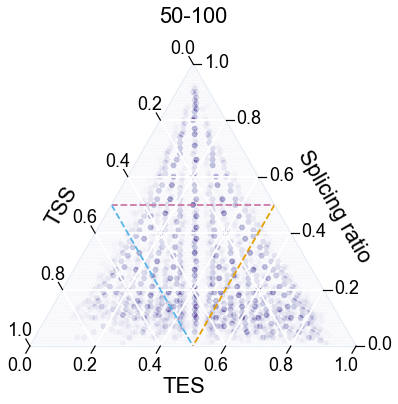

10-50


<Figure size 432x288 with 0 Axes>

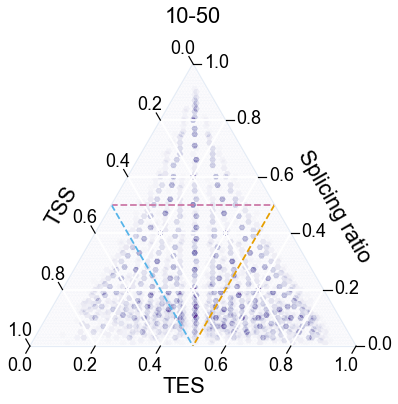

1-10


<Figure size 432x288 with 0 Axes>

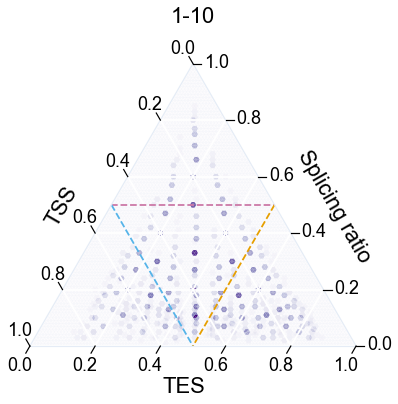

100-max


<Figure size 432x288 with 0 Axes>

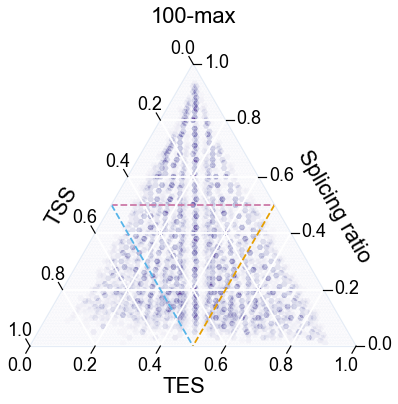

All


<Figure size 432x288 with 0 Axes>

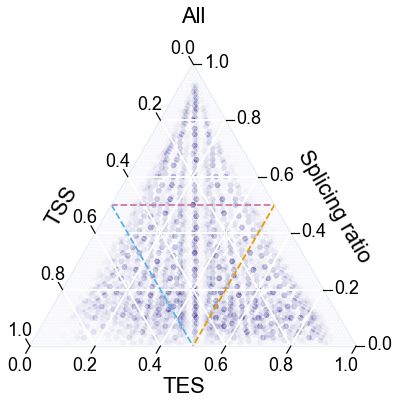

<Figure size 432x288 with 0 Axes>

In [97]:
# plot sector plot for each tpm bin
big_df = pd.DataFrame()
for b in df.tpm_bin.unique().tolist()+['All']:
    print(b)
    ca = cerberus.read(cerberus_h5)
    
    # limit to sample_det
    ca.triplets = ca.triplets.loc[ca.triplets.source=='sample_det']
    
    # get list of gid_sample combos in this tpm bin
    if b != 'All':
        gid_samples = df.loc[df.tpm_bin==b, 'gid_sample'].tolist()
    
        # limit to just the sample + gene combinations that are in this tpm bin
        ca.triplets['gid_sample'] = ca.triplets.gid+'_'+ca.triplets['sample']
        ca.triplets = ca.triplets.loc[ca.triplets.gid_sample.isin(gid_samples)]
    
    # title fmting
    title = b
    
    temp = ca.plot_simplex(top='splicing_ratio',
        density=True,
        density_scale=100,
        density_cmap='Purples',
        log_density=True,
        sectors=True,
        scatter=False,
        legend=False,
        title=title,
        size_scale=0.6,
        density_cbar=False,
        fname=f'figures/ab_bin_sample_det_simplex_{b}.pdf')
    
    temp['tpm_bin'] = b
    big_df = pd.concat([big_df, temp], axis=0)

    plt.show()
    plt.clf()

# # temp = temp[['gid', 'sector']].groupby('sector').count().reset_index().rename({'gid': 'n_genes'}, axis=1)
# # temp['total'] = temp.n_genes.sum()
# # temp['perc'] = (temp['n_genes']/temp['total'])*100

# # sns.set_context('paper', font_scale=2)
# # mpl.rcParams['font.family'] = 'Arial'
# # mpl.rcParams['pdf.fonttype'] = 42
# # plt.figure(figsize=(5,5))

# # ax = sns.barplot(data=temp, y='perc', x='sector',
# #                  palette=c_dict, order=order,
# #                  saturation=1)
# #                  # , height=3, aspect=1.2)
# # ax.spines['right'].set_visible(False)
# # ax.spines['top'].set_visible(False)
# # ax.set_ylabel('% genes in sector')
# # ax.set_xlabel('')

# # def add_perc_2(ax):
# #     ylim = ax.get_ylim()[1]
# #     n_cats = len(ax.patches)
# #     for p in ax.patches:
# #         percentage = '{:.1f}%'.format(p.get_height())
# #         x = p.get_x() + p.get_width() / 2
# #         y = p.get_y() + p.get_height() + ylim*0.01
# #         ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

# # add_perc_2(ax)
# # fname = f'figures/{species}_genes_per_sector.pdf'
# # plt.savefig(fname, dpi=500)
# # plt.show()
# # plt.clf()

In [98]:
big_df.to_csv('triplets_per_tpm_sector.tsv', sep='\t')

In [110]:
big_df = pd.read_csv('triplets_per_tpm_sector.tsv', sep='\t')
big_df.head()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gid_sample,tpm_bin
0,1,sample_det,ENSG00000000419,2.0,2.0,8.0,9.0,4.000000,25.000000,25.000000,50.000000,mixed,DPM1,hffc6,84.884636,ENSG00000000419_hffc6,50-100
1,13,sample_det,ENSG00000001630,3.0,3.0,5.0,5.0,1.666667,39.130435,39.130435,21.739130,mixed,CYP51A1,hffc6,59.510387,ENSG00000001630_hffc6,50-100
2,16,sample_det,ENSG00000002330,2.0,2.0,4.0,4.0,2.000000,33.333333,33.333333,33.333333,mixed,BAD,hffc6,96.524310,ENSG00000002330_hffc6,50-100
3,38,sample_det,ENSG00000004700,1.0,5.0,6.0,15.0,2.000000,12.500000,62.500000,25.000000,tes,RECQL,hffc6,61.761948,ENSG00000004700_hffc6,50-100
4,44,sample_det,ENSG00000004897,1.0,4.0,6.0,9.0,2.400000,13.513514,54.054054,32.432432,tes,CDC27,hffc6,76.815390,ENSG00000004897_hffc6,50-100


In [123]:
def make_sector_source_bar_plots(counts, fname):
    temp = counts[['gid', 'tpm_bin']].groupby('tpm_bin').count().reset_index().rename({'gid':'total_genes'}, axis=1)
    # temp = pd.DataFrame()
    # for source in counts.source.unique():
    #     df = assign_gisx_sector(counts)
    #     df = df.loc[df.source == source]
    #     df = df[['gid', 'tpm_bin', 'sector']].groupby(['tpm_bin', 'sector']).count().reset_index()
    #     df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
    #     df['total_genes'] = df.n_genes.sum()
    #     temp = pd.concat([temp, df])
    temp2 = counts[['gid', 'tpm_bin', 'sector']].groupby(['tpm_bin', 'sector']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
    temp = temp.merge(temp2, how='left', on='tpm_bin')
    temp['perc'] = (temp.n_genes/temp.total_genes)*100

    cat1 = 'sector'
    cat2 = 'tpm_bin'
    # cat2 = 'source'
    # if species == 'human':
    #     cat2_order = ['v40', 'obs_det', 'obs_major']
    # elif species == 'mouse':
    #     cat2_order = ['vM25', 'obs_det', 'obs_major']?
    cat1_order = ['tss', 'splicing', 'tes', 'mixed', 'simple']
    # cat2_order = ['Low (1-10)', 'Medium (10-100)', 'High (100-max)', 'All']
    cat2_order = ['1-10', '10-50', '50-100', '100-max', 'All']
    parent_c_dict, parent_order = get_sector_colors()

    sns.set_context('paper', font_scale=2)
    plt.figure(figsize=(2,20))
    fig, axes = plt.subplots(1, len(cat1_order), figsize=(20,3))
    

    # loop through first category
    for i, c1 in enumerate(cat1_order):
        beep = temp.loc[temp[cat1] == c1]

        c = parent_c_dict[c1]
        c_dict, order = get_shade_colors(c, cat2_order)

        # plotting
        mpl.rcParams['font.family'] = 'Arial'
        mpl.rcParams['pdf.fonttype'] = 42
        # plt.figure(figsize=(3,4))
        ax = sns.barplot(data=beep, y='perc', x=cat2,
                         palette=c_dict, order=order,
                         saturation=1, ax=axes[i])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        xlabel = ''
        if c1 in ['tss', 'tes']:
            c1 = c1.upper()
        ylabel = '% genes + sample * condition in {} sector'.format(c1)

        _ = ax.set(xlabel=xlabel, ylabel=ylabel)
        ax.tick_params(axis="x", rotation=45)
        # if species == 'human':
        #     ax.set_xticklabels(['v40', 'Obs.', 'Obs. major'])
        # elif species == 'mouse':
        #     ax.set_xticklabels(['vM25', 'Obs.', 'Obs. major'])

        def add_perc_2(ax):
            ylim = ax.get_ylim()[1]
            n_cats = len(ax.patches)
            for p in ax.patches:
                percentage = '{:.1f}%'.format(p.get_height())
                x = p.get_x() + p.get_width() / 2
                y = p.get_y() + p.get_height() + ylim*0.01
                ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

        add_perc_2(ax)
    plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6


<Figure size 144x1440 with 0 Axes>

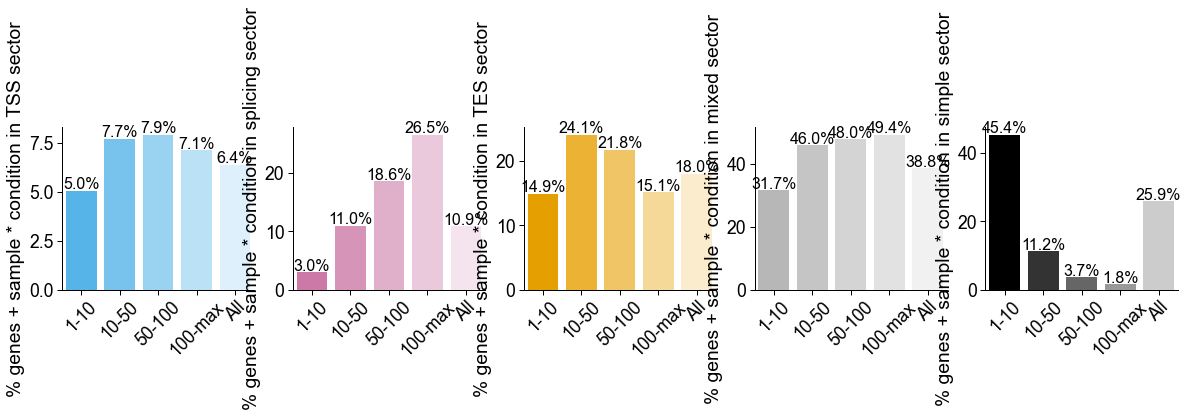

In [124]:
make_sector_source_bar_plots(big_df, 'test.pdf')